# Data Preparation 

Data is processed for models that determine the inclinations of spiral galaxies by leveraging the regression methodologies. 

**See also** [This Notebook](https://github.com/ekourkchi/incNET-data/blob/master/incNET_VGGcnn_withAugmentation/incNET_model_augmentation.ipynb) for the data augmentation of the galaxy sample with binary accept/reject labels. Most of this work has been repeated in that work.


## Augmentation

To prepare data for the full analysis, we increase the resolution of the input images to 128x128. Each images can be rotated arbitrarily, with some additional noise and other tweaks.

Note that the aspect ratio of images should not be changed to preserve the elliptical shape of the projected galaxies, and thus their inclinations.

## Importing external packages

In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random
from datetime import datetime
import json
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
from sklearn.model_selection import train_test_split
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

## Image formats

All images have been preprocessed into 4 separate batches and stored in numpy compressed format, i.e. `npz`.

The batch names follow this naming format `data_128x128_<filter>_originals.npz`, where `<filter>` is to be replaced with either of `g`, `r`, and `i` or `RGB`.
`gri` images are presented in grayscale, in three channels all of which are equivalent. `RGB` images are colorful and have been processed separately.

In [8]:
data = np.load('data_128x128_g_originals.npz')
images_g = data['images'].astype(np.uint8)
labels_g = data['labels'] 
data.close() 
del data

data = np.load('data_128x128_r_originals.npz')
images_r = data['images'].astype(np.uint8)
labels_r = data['labels'] 
data.close() 
del data

data = np.load('data_128x128_i_originals.npz')
images_i = data['images'].astype(np.uint8)
labels_i = data['labels'] 
data.close() 
del data


data = np.load('data_128x128_RGB_originals.npz')
images_RGB = data['images'].astype(np.uint8)
labels_RGB = data['labels'] 
data.close() 
del data

In [69]:
def getImage(pgc, images, labels, ax=None, filt=''):
    
    try:
        indx, = np.where(labels[0]==pgc)
        indx = indx[0]
        
        if ax is None:
            return images[indx], labels[0][indx], labels[1][indx]
        else:
            ax.imshow(images[indx])
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.text(10, 110, labels[0][indx], color='red', fontsize=12)
            ax.text(100, 20, filt, color='magenta', fontsize=12)
            return images[indx], labels[0][indx], labels[1][indx]
    except:
        return None

## Image examination

PGC ID: 1634, Inclination: 77
PGC ID: 1393903, Inclination: 66
PGC ID: 11954, Inclination: 52
PGC ID: 5807368, Inclination: 60


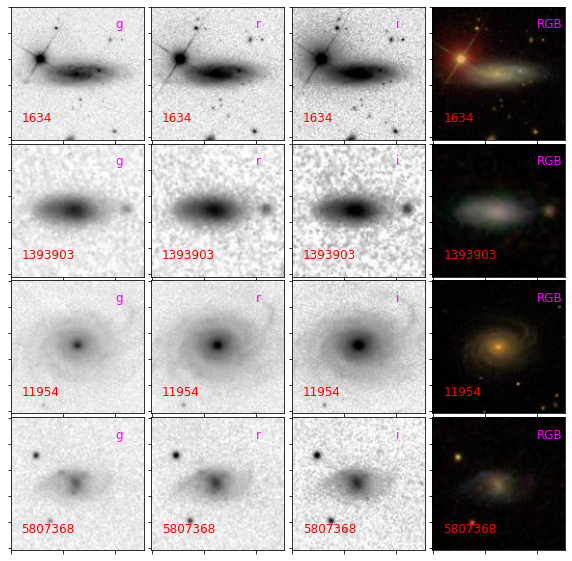

In [70]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10)) 

for i in range(0,4):
    t = i+200
    pgc = labels_RGB[0][t]
    print("PGC ID: {}, Inclination: {}".format(pgc, labels_RGB[1][t]))
    _ = getImage(pgc, images_g,   labels_g,   ax=axes[i][0], filt='g')
    _ = getImage(pgc, images_r,   labels_r,   ax=axes[i][1], filt='r')
    _ = getImage(pgc, images_i,   labels_i,   ax=axes[i][2], filt='i')
    _ = getImage(pgc, images_RGB, labels_RGB, ax=axes[i][3], filt='RGB')

plt.subplots_adjust(hspace=0.03, wspace=0.03)

## Augmentations

We define two variables `seq` and `seqGray` to perform augmentation on the grayscale and colorful images, respectively. The python package `imgaug` is utilized to perform the task of augmentation.

Please refer to [imaug documentation](https://imgaug.readthedocs.io/en/latest/index.html) for more details .

In [4]:
ia.seed(100)

seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),               # bluring the image 50% of times
    iaa.GammaContrast(gamma=(0.97,1.03)),                               # altering the contrast     
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3), per_channel=0.5),  # adding Guassian noise
    iaa.Add((-5, 5), per_channel=0.5),                                  # randomly change of the pixel values
    iaa.Multiply((0.8, 1.2), per_channel=0.5),                          # changing the intensity of channel
    iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 1.0))),                # change images to grayscale overlayed with the original   iaa.Sometimes(0.50, iaa.Grayscale(alpha=1.)),
    iaa.Fliplr(0.5),                                                    # left/right flip (50% of cases)
    iaa.Flipud(0.5),                                                    # up/down flip (50% of cases)
    iaa.Affine(                                                         # affine transformations 
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(0, 255))
    ], random_order=True)


# Grayscale augmentation takes fewer transformations, because all three channels are the same
seqGray = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(255, 255))
    ], random_order=True)

## Auxiliary Functions

In [5]:
def esn_shuffle(array, seed=None):
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(array)
        return array

## Sample Generating Functions

`train_test_creation` takes the `npz` file at each filter, e.g. `data_128x128_g_originals.npz`, and splits the data into training and testing batches.

10% of all galaxies with inclinations greater than 45 degrees are set aside for the testing purpose in file `<outFileRoot>test_000.npz`.

The entire training set is also stored under the name of `<outFileRoot>train_000.npz`.
To perform extra analysis (like bagging), sub-samples of the training set are generated, with the size of 67% of the entire training sample size. The number of sub-sample is set to `m_iter=3`, by default. Each of the sub-samples are stored in `<outFileRoot>train_00<iter>.npz`, where `<outFileRoot>` is the root name of the output files, and `<iter>` is sub-sample iteration number.

*Note that sub-samples overlap as each contain 2/3 of the data drawn randomly from the mother sample, whereas the test sample doesn't overlap with any of the training sub-samples.*

In [7]:
def train_test_creation(npzFile, outFileRoot, m_iter=3):
'''
    npzFile: name of the input npz file that holds the original sample at each band (g, r, i, RGB)
    outFileRoot: the root name of the output products
    m_iter: the number training sub-samples, each consisting of 67% of the whole training sample
'''    
    data = np.load(npzFile)
    images_ = data['images'].astype(np.uint8)
    labels_ = data['labels'] 
    data.close() 
    del data
    
    ix, = np.where(labels_[1,:]>=45)

    images_c = images_[ix]
    labels_c = labels_[1,:][ix]
    pgcIDs_c = labels_[0,:][ix]

    N = images_c.shape[0]
    idx = np.arange(N)
    idx = esn_shuffle(idx, seed=0)
    images_c = images_c[idx]
    labels_c = labels_c[idx]
    pgcIDs_c = pgcIDs_c[idx]

    images_train, images_test, labels_train, labels_test, pgcIDs_train,  pgcIDs_test = train_test_split(images_c, 
                                                                                                        labels_c, 
                                                                                                        pgcIDs_c, 
                                                                                                        test_size=0.15,
                                                                                                        random_state=100
                                                                                                       )
    ## Storing train/test samples
    ###############################################
    npzTest = outFileRoot+'test_000.npz'
    np.savez_compressed(npzTest, 
                        images=images_test, 
                        labels=labels_test, 
                        pgcIDs=pgcIDs_test)
    
    print('created ...', npzTest)
    
    
    npzTrain = outFileRoot+'train_000.npz'
    np.savez_compressed(npzTrain, 
                        images=images_train, 
                        labels=labels_train, 
                        pgcIDs=pgcIDs_train)
    
    print('created ...', npzTrain)
    ###############################################

    del images_
    del labels_

    del images_c
    del labels_c
    del pgcIDs_c

    
    ## Storing m_iter training sub-samples, each holding 2/3 of the entire training set
    ###############################################
    N = images_train.shape[0]
    n = N*2//3
    pgcIDs_train_list = []
    
    for jj in range(m_iter):
        idx = np.arange(N)
        idx = esn_shuffle(idx, seed=100*(jj+1))
        images_train_ = images_train[idx][:n]
        labels_train_ = labels_train[idx][:n]
        pgcIDs_train_ = pgcIDs_train[idx][:n]
        
        images_test_ = images_train[idx][n:]
        labels_test_ = labels_train[idx][n:]
        pgcIDs_test_ = pgcIDs_train[idx][n:]
        
        npzTrain = outFileRoot+'train_00'+str(jj+1)+'.npz'
        np.savez_compressed(npzTrain, 
                            images=images_train_, 
                            labels=labels_train_, 
                            pgcIDs=pgcIDs_train_)
        print('created ...', npzTrain)
        
        
        npzTest = outFileRoot+'test_00'+str(jj+1)+'.npz'
        np.savez_compressed(npzTest, 
                            images=images_test_, 
                            labels=labels_test_, 
                            pgcIDs=pgcIDs_test_)
        
        print('created ...', npzTest)
        pgcIDs_train_list.append(pgcIDs_train_)
        
        del images_train_
        
    return pgcIDs_test, pgcIDs_train_list

The action of the following function is very similar to that of `train_test_creation`. Here, the difference is that train/test spits are taken as input parameters `pgcIDs_test` and `pgcIDs_train_list`. This is to ensure that all test/train splits are similar to each other at all various bands, `g`, `r`, `i`, and `RGB`.

In [6]:
def train_test_replication(npzFile, outFileRoot, pgcIDs_test, pgcIDs_train_list):
    
    m_iter = len(pgcIDs_train_list)
    
    data = np.load(npzFile)
    images_ = data['images'].astype(np.uint8)
    labels_ = data['labels'] 
    data.close() 
    del data
    
    ix, = np.where(labels_[1,:]>=45)
    images_c = images_[ix]
    labels_c = labels_[1,:][ix]
    pgcIDs_c = labels_[0,:][ix]
    
    idx = np.isin(pgcIDs_c, pgcIDs_test)
    npzTest = outFileRoot+'test_000.npz'
    np.savez_compressed(npzTest, 
                        images=images_c[idx], 
                        labels=labels_c[idx], 
                        pgcIDs=pgcIDs_c[idx])  
    print('created ...', npzTest)
    
    
    idx = np.logical_not(np.isin(pgcIDs_c, pgcIDs_test))
    npzTrain = outFileRoot+'train_000.npz'
    np.savez_compressed(npzTrain, 
                        images=images_c[idx], 
                        labels=labels_c[idx], 
                        pgcIDs=pgcIDs_c[idx])  
    print('created ...', npzTrain)
    
    
    for jj in range(m_iter):
        
        idx = np.isin(pgcIDs_c, pgcIDs_train_list[jj])
        npzTrain = outFileRoot+'train_00'+str(jj+1)+'.npz'
        np.savez_compressed(npzTrain, 
                            images=images_c[idx], 
                            labels=labels_c[idx], 
                            pgcIDs=pgcIDs_c[idx])  
        print('created ...', npzTrain)
        
        
        idx = np.logical_not(np.isin(pgcIDs_c, pgcIDs_train_list[jj]))
        npzTest = outFileRoot+'test_00'+str(jj+1)+'.npz'
        np.savez_compressed(npzTest, 
                            images=images_c[idx], 
                            labels=labels_c[idx], 
                            pgcIDs=pgcIDs_c[idx])  
        print('created ...', npzTest)
        
    del images_
    del labels_

    del images_c
    del labels_c
    del pgcIDs_c    

Here, we chose the `r`-band sample to create the train/test split and used the same configuration to split data at other filters, `g`, `i`, and `RGB`.

*Note:* the sample has not yet been augmented.

In [106]:
band = 'r'
pgcIDs_test, pgcIDs_train_list = train_test_creation('./data_128x128_'+band+'_originals.npz', 
                                                     'samples/'+band+'_128x128_')

for band in ['RGB', 'g', 'i']:
    train_test_replication('./data_128x128_'+band+'_originals.npz', 
                           'samples/'+band+'_128x128_', 
                           pgcIDs_test, 
                           pgcIDs_train_list)

created ... samples/r_128x128_test_000.npz
created ... samples/r_128x128_train_000.npz
created ... samples/r_128x128_train_001.npz
created ... samples/r_128x128_test_001.npz
created ... samples/r_128x128_train_002.npz
created ... samples/r_128x128_test_002.npz
created ... samples/r_128x128_train_003.npz
created ... samples/r_128x128_test_003.npz
created ... samples/RGB_128x128_test_000.npz
created ... samples/RGB_128x128_train_000.npz
created ... samples/RGB_128x128_train_001.npz
created ... samples/RGB_128x128_test_001.npz
created ... samples/RGB_128x128_train_002.npz
created ... samples/RGB_128x128_test_002.npz
created ... samples/RGB_128x128_train_003.npz
created ... samples/RGB_128x128_test_003.npz
created ... samples/g_128x128_test_000.npz
created ... samples/g_128x128_train_000.npz
created ... samples/g_128x128_train_001.npz
created ... samples/g_128x128_test_001.npz
created ... samples/g_128x128_train_002.npz
created ... samples/g_128x128_test_002.npz
created ... samples/g_128x1

## Examining samples

Below, we test the train and test samples.

In [72]:
## i-band training images are imported here
data = np.load('./samples/i_128x128_train_000.npz')
images = data['images'].astype(np.uint8)
labels = data['labels'] 
pgcIDs = data['pgcIDs']
del data

In [74]:
n = len(labels)
indices = np.arange(n)

for i in range(45,90,5):

        if i==45:
            idx = indices[((labels>=i)&(labels<=i+5))]
        else:
            idx = indices[((labels>i)&(labels<=i+5))]
        
        print("inclinations ({}-{}), number: {}".format(i, i+5, len(idx)))

inclinations (45-50), number: 377
inclinations (50-55), number: 1185
inclinations (55-60), number: 931
inclinations (60-65), number: 1143
inclinations (65-70), number: 1026
inclinations (70-75), number: 1671
inclinations (75-80), number: 1769
inclinations (80-85), number: 1751
inclinations (85-90), number: 2769


Text(0.5, 1.0, 'Train sample (i-band)')

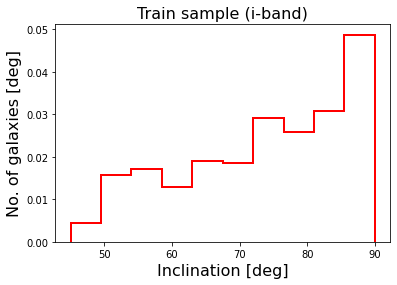

In [92]:
plt.hist(labels, density=True, linewidth=2, histtype='step', color='r')

plt.xlabel("Inclination [deg]", fontsize=16)
plt.ylabel("No. of galaxies [deg]", fontsize=16)
plt.title("Train sample (i-band)", fontsize=16)

The following section can be executed separately after all initial training sets are generated.

### Run this part separately .....

Importing all training samples

In [10]:
%%time 

data = np.load('samples/RGB_128x128_train_000.npz')
images_RGB = data['images'].astype(np.uint8)
labels_RGB = data['labels'] 
pgcIDs_RGB = data['pgcIDs']
N = images_RGB.shape[0]
filter_RGB = np.chararray(N)
filter_RGB[:] = 'c'
data.close() 
del data


data = np.load('samples/g_128x128_train_000.npz')
images_g = data['images'].astype(np.uint8)
labels_g = data['labels'] 
pgcIDs_g = data['pgcIDs']
N = images_g.shape[0]
filter_g = np.chararray(N)
filter_g[:] = 'g'
data.close() 
del data

data = np.load('samples/r_128x128_train_000.npz')
images_r = data['images'].astype(np.uint8)
labels_r = data['labels'] 
pgcIDs_r = data['pgcIDs']
N = images_r.shape[0]
filter_r = np.chararray(N)
filter_r[:] = 'r'
data.close() 
del data

data = np.load('samples/i_128x128_train_000.npz')
images_i = data['images'].astype(np.uint8)
labels_i = data['labels'] 
pgcIDs_i = data['pgcIDs']
N = images_i.shape[0]
filter_i = np.chararray(N)
filter_i[:] = 'i'
data.close() 
del data

CPU times: user 12.9 s, sys: 544 ms, total: 13.4 s
Wall time: 13.5 s


### Concatenating all grayscale images

We bundle all grayscale images together.

In order to avoid inducing other undesired biases, we demand that each training batch to have the same number of grayscale and colorful images. We invert half of the grayscale images to ensure that both black and white backgrounds are considered in the training process.

In [11]:
images_gri = np.concatenate((images_g, images_r, images_i))
labels_gri = np.concatenate((labels_g, labels_r, labels_i))
pgcIDs_gri = np.concatenate((pgcIDs_g, pgcIDs_r, pgcIDs_i))
filter_gri = np.concatenate((filter_g, filter_r, filter_i))

## Auxiliary Functions

### Augmenting an array of images

`augment_N` takes the image array and augment it several times. `N` number of images are then taken randomly and returned as output.  

In [12]:
def augment_N(images, labels, pgcIDs, filter, N, isGray=True, seed=0):
'''
    images, labels, pgcIDs: input data
    filer: the band-pass of the input data
    N: the number of the output augmented images
    isGray: True: grayscale images, False: colorful images 
    seed: the randomness state
'''
    
    if isGray:
        images_aug = seqGray(images=images)
    else:
        images_aug = seq(images=images)
    labels_aug = labels
    pgcIDs_aug = pgcIDs
    filter_aug = filter
    
    ii = 0 
    while len(labels_aug)<N:   # The image array is augmented until its size grows bigger than N
        if isGray:
            images_aug = np.concatenate((images_aug,seqGray(images=images)))
        else:
            images_aug = np.concatenate((images_aug,seq(images=images)))         
        labels_aug = np.concatenate((labels_aug, labels))
        pgcIDs_aug = np.concatenate((pgcIDs_aug, pgcIDs))
        filter_aug = np.concatenate((filter_aug, filter))
        
    
    # returning N number of galaxies randomly
    indx = esn_shuffle(np.arange(len(labels_aug)), seed=seed)
    images_aug = images_aug[indx][:N]
    labels_aug = labels_aug[indx][:N]
    pgcIDs_aug = pgcIDs_aug[indx][:N]
    filter_aug = filter_aug[indx][:N]
    
    return images_aug, labels_aug, pgcIDs_aug, filter_aug

## Generating augmented samples with uniform distribution of inclinations

Function `uniformer` takes the entire array of images, and divides it into the inclination bins of size 5 starting from 45 degrees. Each of the $5^o$ sub-samples are augmented separately using Function `augment_N`.

`N=1000` means that each of the $5^o$ intervals have 1,000 galaxies after the augmentation process. 

In [13]:
import copy 

def uniformer(images, labels, pgcIDs, filter, N=1000, isGray=True, seed=0):

    '''
    images, labels, pgcIDs: input data
    filer: the band-pass of the input data
    N: the number of the augmented images within 5 degrees of inclination interval
    isGray: True: grayscale images, False: colorful images 
    seed: the randomness state
    '''
    
    n = len(labels)
    indices = np.arange(n)
    
    for i in range(45,90,5):

        if i==45:   # taking care of boundaries
            idx = indices[((labels>=i)&(labels<=i+5))]
        else:
            idx = indices[((labels>i)&(labels<=i+5))]
        
        ## augmenting each 5-deg interval to hold N galaxies
        images_aug, labels_aug, pgcIDs_aug, filter_aug = augment_N(images[idx], 
                                                                   labels[idx], 
                                                                   pgcIDs[idx], 
                                                                   filter[idx], N, isGray=True, seed=seed)
        if i>45:
            images_aug_ = np.concatenate((images_aug_, images_aug))
            labels_aug_ = np.concatenate((labels_aug_, labels_aug))
            pgcIDs_aug_ = np.concatenate((pgcIDs_aug_, pgcIDs_aug))
            filter_aug_ = np.concatenate((filter_aug_, filter_aug))
        else:
            images_aug_ = copy.deepcopy(images_aug)
            labels_aug_ = copy.deepcopy(labels_aug)
            pgcIDs_aug_ = copy.deepcopy(pgcIDs_aug)
            filter_aug_ = copy.deepcopy(filter_aug)

    return images_aug_, labels_aug_, pgcIDs_aug_, filter_aug_

## Batch generation

- The training batches are generated here. Each batch consists of the same number of grayscale and colorful images. 
- Half of the grayscale images are inverted to avoid overfitting

In [14]:
## Generating 50 batches of augmented training sample
for i in range(50):
    t1 =  datetime.now()

    ia.seed(2*i+12)
    
    ## The gri ensebmle is almost 3 times larger than the RGB sample, so N=3000 is three times larger
    ## than that for the RGB images
    images_aug_gri, labels_aug_gri, pgcIDs_aug_gri, filter_aug_gri = uniformer(images_gri, 
                                                                               labels_gri, 
                                                                               pgcIDs_gri, 
                                                                               filter_gri, 
                                                                               N=3000, isGray=True, seed=3*i+36)
    ia.seed(5*i+25)
    
    images_aug_RGB, labels_aug_RGB, pgcIDs_aug_RGB, filter_aug_RGB = uniformer(images_RGB, 
                                                                               labels_RGB, 
                                                                               pgcIDs_RGB, 
                                                                               filter_RGB, 
                                                                               N=1000, isGray=False, seed=3*i+41)
    N_RGB = len(labels_aug_RGB)
    N_gri = len(labels_aug_gri)

    indx = esn_shuffle(np.arange(N_gri), seed=6*i+40)
    images_aug = images_aug_gri[indx][:N_RGB]
    labels_aug = labels_aug_gri[indx][:N_RGB]
    pgcIDs_aug = pgcIDs_aug_gri[indx][:N_RGB]
    filter_aug = filter_aug_gri[indx][:N_RGB]
    
    ## half of the grayscale images are drawn randomly and inverted
    n = len(images_aug)
    p = int(n/2)
    images_aug[:p] = 255 - images_aug[:p]

    ia.seed(2*i+51)
    images_aug = np.concatenate((images_aug_RGB,images_aug))
    labels_aug = np.concatenate((labels_aug_RGB,labels_aug))
    pgcIDs_aug = np.concatenate((pgcIDs_aug_RGB,pgcIDs_aug))
    filter_aug = np.concatenate((filter_aug_RGB,filter_aug))
    
    indx = np.arange(len(images_aug))
    indx = esn_shuffle(indx, seed=32*i+13)
    images_aug = images_aug[indx]
    labels_aug = labels_aug[indx]
    pgcIDs_aug = pgcIDs_aug[indx]
    filter_aug = filter_aug[indx]
    
    ## saving the output product in npz format
    npzname = 'Uset0_npz/128x128_train_aug_'+'%02d'%(i+1)+'.npz'
    np.savez_compressed(npzname, 
                            images=images_aug, 
                            labels=labels_aug, 
                            pgcIDs=pgcIDs_aug,
                            filter=filter_aug
                       )
    
    t2 =  datetime.now()
    print(npzname+' ... saved.')
    print("Process time: ", i+1, t2-t1)

Uset0_npz/128x128_train_aug_01.npz ... saved.
Process time:  1 0:02:03.436570
Uset0_npz/128x128_train_aug_02.npz ... saved.
Process time:  2 0:01:58.577849
Uset0_npz/128x128_train_aug_03.npz ... saved.
Process time:  3 0:01:59.926499
Uset0_npz/128x128_train_aug_04.npz ... saved.
Process time:  4 0:02:00.344571
Uset0_npz/128x128_train_aug_05.npz ... saved.
Process time:  5 0:02:00.509477
Uset0_npz/128x128_train_aug_06.npz ... saved.
Process time:  6 0:01:58.622676
Uset0_npz/128x128_train_aug_07.npz ... saved.
Process time:  7 0:02:02.287391
Uset0_npz/128x128_train_aug_08.npz ... saved.
Process time:  8 0:01:57.804623
Uset0_npz/128x128_train_aug_09.npz ... saved.
Process time:  9 0:01:58.251063
Uset0_npz/128x128_train_aug_10.npz ... saved.
Process time:  10 0:01:57.826993
Uset0_npz/128x128_train_aug_11.npz ... saved.
Process time:  11 0:01:57.933262
Uset0_npz/128x128_train_aug_12.npz ... saved.
Process time:  12 0:01:58.420060
Uset0_npz/128x128_train_aug_13.npz ... saved.
Process time:  

## Examining a training batch

In [79]:
data = np.load('Uset0_npz/128x128_train_aug_01.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
pgcIDs_ = data['pgcIDs']
filter_  = data['filter']
data.close() 
del data

images_.shape, labels_.shape, pgcIDs_.shape, filter_.shape

((18000, 128, 128, 3), (18000,), (18000,), (18000,))

### The distribution of inclinations

As expected, each batch covers various inclinations uniformly. This reduces any biases that originates from the data imbalance.

Text(0.5, 1.0, 'Augmented Training (01-sample)')

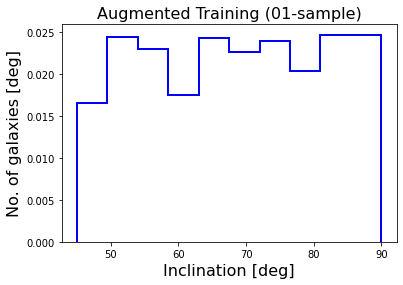

In [83]:
plt.hist(labels_, density=True, linewidth=2, histtype='step', color='b')

plt.xlabel("Inclination [deg]", fontsize=16)
plt.ylabel("No. of galaxies [deg]", fontsize=16)
plt.title("Augmented Training (01-sample)", fontsize=16)

### Visualizing images

100 images of an example batch are displayed below

- The numbers of colorful (*RGB*) and grayscale (*gri*) images are equal
- The numbers of black-on-white and white-on-black images are the same
- `g`, `r`, `i` images have the equal chance of appearance in each batch

In each panel, the PGC ID of the galaxy is in cyan. Red is the inclination and magenta is the image pass-band, i.e. `g`, `r`, `i` and `c`, where `c` stands for `RGB`.

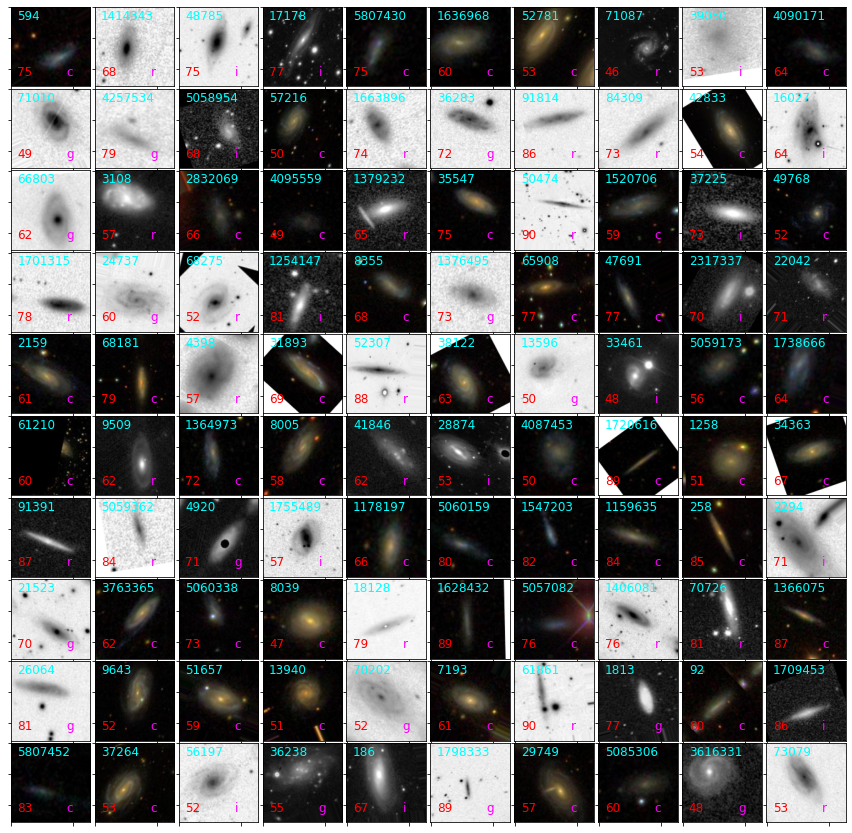

In [91]:
n = 10
m = 10

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
for i in range(n):
    for j in range(m):

        ax = axes[i][j]
        ax.imshow(images_[t,:,:])

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        
        ax.text(10, 110, labels_[t], color='red', fontsize=12)
        ax.text(90, 110, filter_[t].decode("utf-8") , color='magenta', fontsize=12)
        ax.text(10, 20, pgcIDs_[t], color='cyan', fontsize=12)

        t+=1
  
plt.subplots_adjust(hspace=0.03, wspace=0.03)